## Installing Libraries and Importing Datasets



In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()  # This will prompt you to upload the file.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fatimaseemabmsai","key":"1470e9a86547cdc468b8eb4965d9ebd9"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download jessicali9530/celeba-dataset

Dataset URL: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset
License(s): other


In [5]:
!unzip -q celeba-dataset.zip -d /content/celeba

In [6]:
!ls content/celeba

ls: cannot access 'content/celeba': No such file or directory


In [7]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Dataset Preprocessing

In [8]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [9]:
# Root directory for dataset
dataroot = "/content/celeba"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

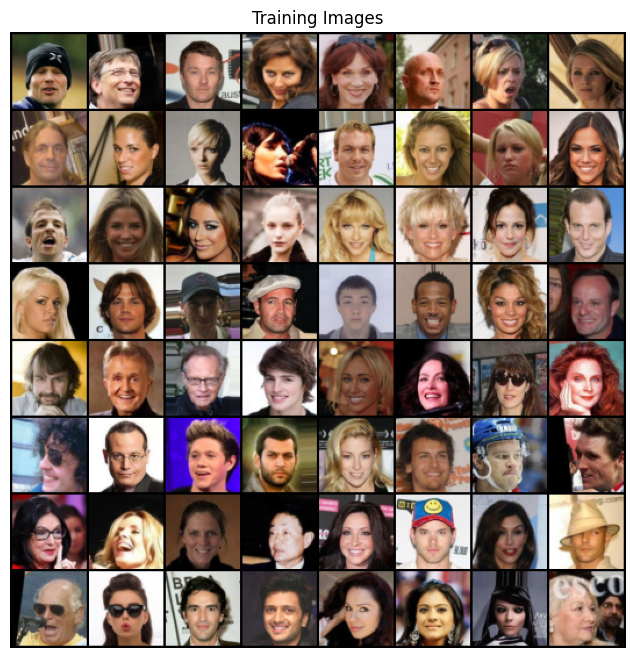

In [10]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [11]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Generator Part

In [12]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
# netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


## Discriminator Part

In [14]:

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
# netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [16]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 0.9
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

## Training

In [ ]:
# Training Loop
save_dir='/content/drive/MyDrive/UNet/'
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    torch.save({
      'epoch': epoch,
      'netG_state_dict': netG.state_dict(),
      'netD_state_dict': netD.state_dict(),
      'optimizerG_state_dict': optimizerG.state_dict(),
      'optimizerD_state_dict': optimizerD.state_dict(),
      'G_losses': G_losses,
      'D_losses': D_losses,
  }, os.path.join(save_dir, f'model_epoch_{epoch}.pth'))

Starting Training Loop...
[0/100][0/1583]	Loss_D: 0.0820	Loss_G: 34.6780	D(x): 0.9479	D(G(z)): 0.0000 / 0.0000
[0/100][50/1583]	Loss_D: 0.9811	Loss_G: 14.0218	D(x): 0.6335	D(G(z)): 0.0003 / 0.0001
[0/100][100/1583]	Loss_D: 0.4546	Loss_G: 3.1518	D(x): 0.7884	D(G(z)): 0.0983 / 0.0601
[0/100][150/1583]	Loss_D: 0.6417	Loss_G: 5.6431	D(x): 0.9016	D(G(z)): 0.3561 / 0.0118
[0/100][200/1583]	Loss_D: 0.7515	Loss_G: 6.7556	D(x): 0.8893	D(G(z)): 0.3882 / 0.0020
[0/100][250/1583]	Loss_D: 1.4693	Loss_G: 5.3454	D(x): 0.4038	D(G(z)): 0.0044 / 0.0188
[0/100][300/1583]	Loss_D: 0.5391	Loss_G: 4.2938	D(x): 0.8662	D(G(z)): 0.2621 / 0.0275
[0/100][350/1583]	Loss_D: 0.4304	Loss_G: 4.3661	D(x): 0.8042	D(G(z)): 0.1566 / 0.0234
[0/100][400/1583]	Loss_D: 1.2356	Loss_G: 6.7867	D(x): 0.8870	D(G(z)): 0.5722 / 0.0044
[0/100][450/1583]	Loss_D: 0.4234	Loss_G: 5.1531	D(x): 0.8919	D(G(z)): 0.2271 / 0.0141
[0/100][500/1583]	Loss_D: 0.4783	Loss_G: 3.9412	D(x): 0.7553	D(G(z)): 0.0557 / 0.0379
[0/100][550/1583]	Loss_D: 1.2

##Loading and Training from Checkpoint

In [33]:
import torch
import os
# map_location=torch.device('cpu')

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Define the path to the saved model checkpoint
checkpoint_path = '/content/drive/MyDrive/UNet/model_epoch_50.pth'  # Replace X with the epoch number you want to load

# Load the checkpoint
checkpoint = torch.load(checkpoint_path,map_location=device)

# Load the state dictionaries
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

# Load the loss histories
G_losses = checkpoint['G_losses']
D_losses = checkpoint['D_losses']

# Set the starting epoch (if you want to continue from the next epoch)
start_epoch = checkpoint['epoch'] + 1

In [34]:
print("Starting Training Loop...")
# start_epoch=51
iters = 0
save_dir='/content/drive/MyDrive/UNet/'
# Lists to keep track of progress
img_list = []
# For each epoch
for epoch in range(start_epoch, 100):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

    # Save the model checkpoint
    torch.save({
        'epoch': epoch,
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict(),
        'G_losses': G_losses,
        'D_losses': D_losses,
    }, os.path.join(save_dir, f'model_epoch_{epoch}.pth'))

Starting Training Loop...
[51/100][0/1583]	Loss_D: 0.4029	Loss_G: 3.4518	D(x): 0.7984	D(G(z)): 0.0104 / 0.0322
[51/100][50/1583]	Loss_D: 0.3647	Loss_G: 4.0772	D(x): 0.8631	D(G(z)): 0.0118 / 0.0150
[51/100][100/1583]	Loss_D: 0.3686	Loss_G: 5.2264	D(x): 0.9211	D(G(z)): 0.0196 / 0.0040
[51/100][150/1583]	Loss_D: 0.3594	Loss_G: 5.1404	D(x): 0.9168	D(G(z)): 0.0128 / 0.0049
[51/100][200/1583]	Loss_D: 0.4145	Loss_G: 4.7986	D(x): 0.9533	D(G(z)): 0.0381 / 0.0065
[51/100][250/1583]	Loss_D: 0.3647	Loss_G: 5.0487	D(x): 0.9111	D(G(z)): 0.0174 / 0.0052
[51/100][300/1583]	Loss_D: 0.4666	Loss_G: 2.8745	D(x): 0.7248	D(G(z)): 0.0050 / 0.0576
[51/100][350/1583]	Loss_D: 0.5691	Loss_G: 4.4413	D(x): 0.9413	D(G(z)): 0.1505 / 0.0101
[51/100][400/1583]	Loss_D: 0.3854	Loss_G: 4.3838	D(x): 0.8170	D(G(z)): 0.0069 / 0.0113
[51/100][450/1583]	Loss_D: 0.4147	Loss_G: 4.9086	D(x): 0.9542	D(G(z)): 0.0337 / 0.0060
[51/100][500/1583]	Loss_D: 0.4234	Loss_G: 3.9919	D(x): 0.9182	D(G(z)): 0.0633 / 0.0166
[51/100][550/1583]	L

KeyboardInterrupt: 

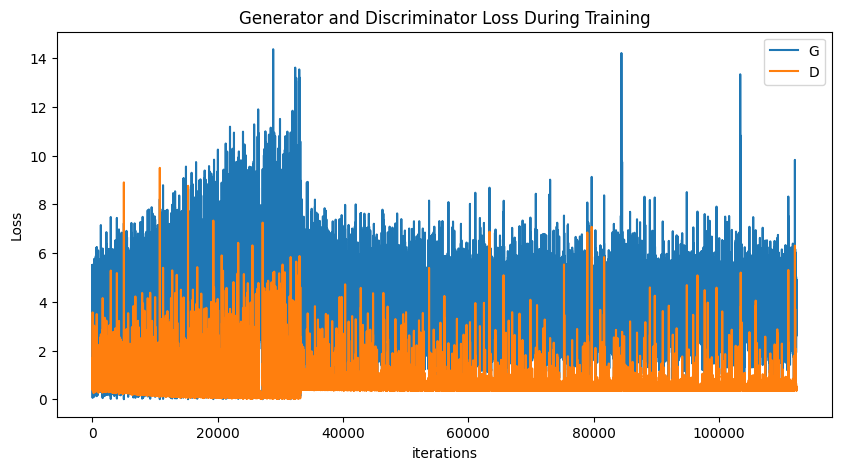

In [39]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [36]:
img_list=[]
fake = netG(fixed_noise).detach().cpu()
img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

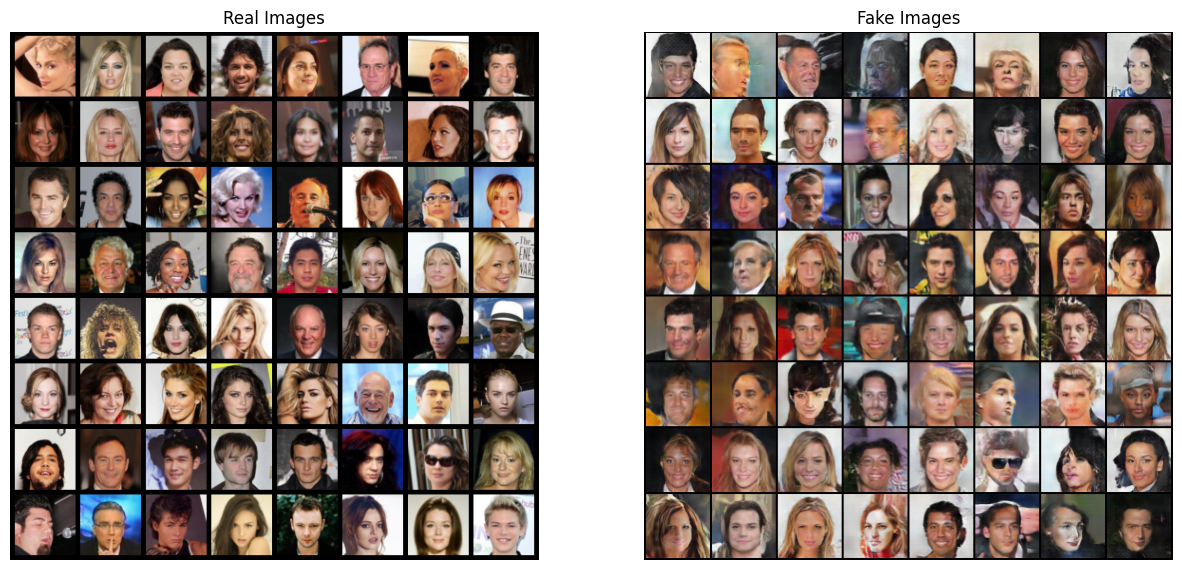

In [37]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [38]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Define the path to the saved model checkpoint
checkpoint_path = '/content/drive/MyDrive/UNet/model_epoch_70.pth'  # Replace X with the epoch number you want to load

# Load the checkpoint
checkpoint = torch.load(checkpoint_path,map_location=device)

# Load the state dictionaries
netG.load_state_dict(checkpoint['netG_state_dict'])
netD.load_state_dict(checkpoint['netD_state_dict'])
optimizerG.load_state_dict(checkpoint['optimizerG_state_dict'])
optimizerD.load_state_dict(checkpoint['optimizerD_state_dict'])

# Load the loss histories
G_losses = checkpoint['G_losses']
D_losses = checkpoint['D_losses']
